In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [14]:
TRAIN_DIR = '/notebooks/face-recognition-biometric-sys/training-imgs'
TEST_DIR = '/notebooks/face-recognition-biometric-sys/test-imgs'
IMG_SIZE = 50 #50x50 px
LEARNING_RATE = 1e-3

MODEL_NAME = 'facerec-{}-{}.pb'.format(LEARNING_RATE, 'bio-6conv')

In [3]:
# defining labels for traning data
# using hot one technique
# [1,0,0,0] = anders from front in img & [0,1,0,0] = anders with right eye cloed in img and so on..
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'anders-front': return [1,0,0,0]
    elif word_label == 'anders-right-eye-closed': return [0,1,0,0]
    elif word_label == 'anders-left-eye-closed': return [0,0,1,0]
    elif word_label == 'anders-open-mouth': return [0,0,0,1]
    

In [4]:
# convert feature to 2d greyscale data
# creates the traning data with labels -> 
# anders-front = [[[greyscale img data], [1,0,0,0]]], 
# anders-right-eye-closed = [[[greyscale img data], [0,1,0,0]]]

# whole traning data example (with first front and second right-eye): 
# [[[greyscale img data], [1,0,0,0]], [[greyscale img data], [0,1,0,0]]]

# images gets resized to 50x50px
# the traning data gets shuffled to make sure that they are all random and we dont have any sitiuations where all the
# images come in order.
# the whole data gets saved out to 'bio_traning_data.npy' file
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        raw_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if raw_img is not None:
            img = cv2.resize(raw_img, (IMG_SIZE, IMG_SIZE))
            training_data.append([np.array(img), np.array(label)])
        
    shuffle(training_data)
    np.save('bio_traning_data.npy', training_data)
    return training_data

In [21]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('bio_test_data.npy', testing_data)
    return testing_data

In [22]:
train_data = create_train_data()

# if the data already is processed simply load it
# train_data = np.load('train_data.npy')

100%|██████████| 3991/3991 [01:34<00:00, 40.88it/s]


In [7]:
# Setting up the CNN with tflearn
# using two conv. layers with max pooling
# 3 layers in total
# a droprate of 80%
# activation function is set to relu
# final activation function is softmax since we want multi-classification
# optimize algorithm is adam and loss algorithm is categorical crossentropy
# both the optimizer and loss functions are used for back-prop
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

# Adding more layers for test.

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

# These layers above is just for testing.

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

# fully connected layer with 4 outputs/classes, (front, right-eye, left-eye, open-mouth)
convnet = fully_connected(convnet, 4, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LEARNING_RATE, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log',  tensorboard_verbose=3)

In [8]:
# Check if we already have trained on a model, if so load the weights and continue
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model loaded!')

In [9]:
# Seperating data to traning data and test data
#train = train_data[:-500]
#test = train_data[-500:]

# changed split for smaller data size
#train = train_data[:-369]
#test = train_data[-369:]

# Seperating data to traning data and test data (3992 img dataset)
train = train_data[:-1996]
test = train_data[-1996:]

In [10]:
# traning data
# feature sets
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# labels
Y = [i[1] for i in train]

# test data (for accuracy)
# feature sets
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# labels
test_y = [i[1] for i in test]

In [11]:
# Traning the conv net - 5 epoch = 5 traning cycles 
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 319  | total loss: 0.30647 | time: 11.433s
| Adam | epoch: 010 | loss: 0.30647 - acc: 0.8823 -- iter: 1984/1995
Training Step: 320  | total loss: 0.28568 | time: 15.048s
| Adam | epoch: 010 | loss: 0.28568 - acc: 0.8909 | val_loss: 0.21870 - val_acc: 0.9148 -- iter: 1995/1995
--


In [ ]:
# command for running tensorboard
# tensorboard --logdir='log'

In [12]:
model.save(MODEL_NAME)

INFO:tensorflow:/notebooks/face-recognition-biometric-sys/facerec-0.001-bio-2conv-light.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 1600/1600 [00:31<00:00, 51.46it/s]


2
3
3
0
2
3
0
1
3
0
3
3


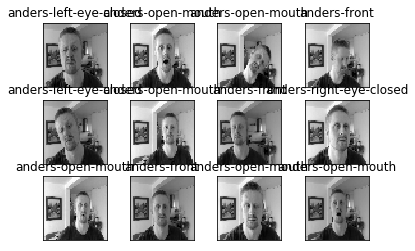

In [23]:
import matplotlib.pyplot as plt

# if we dont have this file yet
test_data = process_test_data()
# if we do
#test_data = np.load('bio_test_data.npy')

fig = plt.figure()

# iterating over the first 12 elements in test_data
for num, data in enumerate(test_data[:12]):
    # front: [1,0,0,0]
    # right-eye: [0,1,0,0]
    # left-eye: [0,0,1,0]
    # mouth: [0,0,0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 0: str_label='anders-front'
    elif np.argmax(model_out) == 1: str_label='anders-right-eye-closed'
    elif np.argmax(model_out) == 2: str_label='anders-left-eye-closed'
    elif np.argmax(model_out) == 3: str_label='anders-open-mouth'
    
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()